# OpenCV Overlay: OpticalFlow

<img src=attachment:image.png width=350 align=right>
This notebook extends the examples of OpenCV applications to OpticalFlow. Here we run through the process of computing optical flow in software, profile it and then accelerate it in hardware and measure the performance speedup. OptcalFlow is a more complicated function which measures the movement of objects in a scene and the gains we see when accelerating in FPGA is more significant. OpticalFlow also has a number of algorithmic variations so in this example, we will compare the OpenCV Farneback algorithm with the xFOpenCV dense non-pyramidal Lucas-Kanade algoirthm.
1. Program overlay
2. Run SW OpticalFlow and measure performance
3. Run HW OpticalFlow and measure performance
4. Plot performance
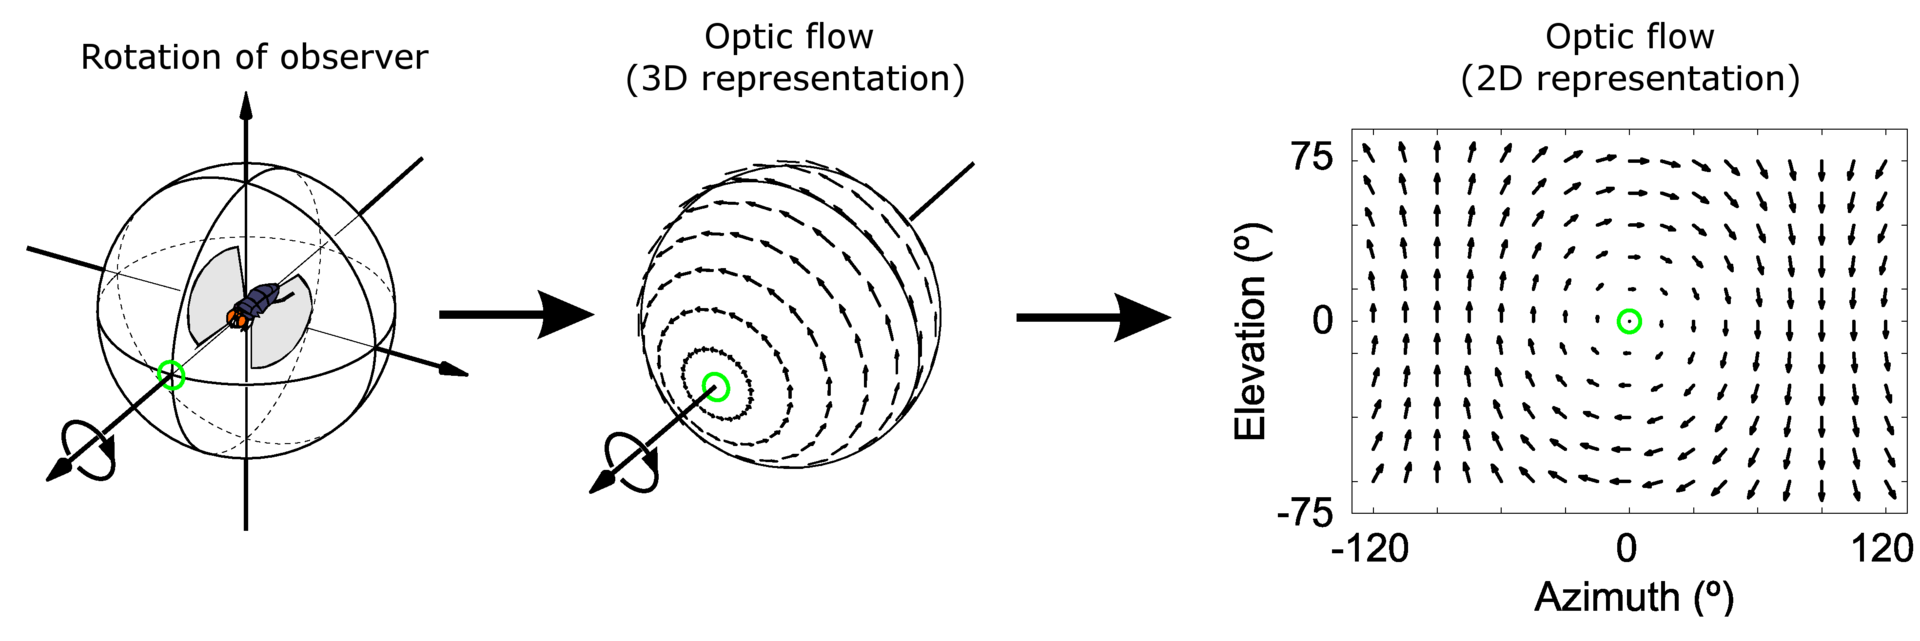

## Program overlay

Here we program the overlay on the FPGA, load the associated overlay library and load the PYNQ xlnk memory manager library.

In [ ]:
import cv2 #NOTE: This needs to be loaded first

# Load calcOpticalFlowDenseNonPyrLK overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2CalcOpticalFlowDenseNonPyrLK.bit")
bs.download()
import pynq_cv.overlays.xv2CalcOpticalFlowDenseNonPyrLK as xv2

# Load xlnk memory mangager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2CalcOpticalFlowDenseNonPyrLK.so')
mem_manager = Xlnk()

## Setup helper functions

Here, we set up IPython based imshow call which encode OpenCV image data to jpeg before displaying it in the notebook. Other methods of displaying image data would perform similar conversions as well.

In [ ]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

## Run SW OpticalFlow and measure performance
We first run our the dense opticalflow algorithm Farneback in software only mode, being sure to enable profiling. We also measure overall FPS. The first cell measures the results from a set of test images. The second cell allows opticalflow to be computed on images from the webcam.
* [OpenCV Farneback](https://docs.opencv.org/3.2.0/de/d9e/classcv_1_1FarnebackOpticalFlow.html)

Compute opticalflow on test images.

In [ ]:
%%prun -s cumulative -q -l 10 -T prunSW_test
import numpy as np
import time

frame1 = cv2.imread('./images/vtest/scene00002.png')
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
yuv = np.zeros_like(frame1)

num_frames = 3
start = time.time()
for i in range(num_frames):
    fileName = ('./images/vtest/scene0000' + str(i+3) + '.png')
    print(fileName)
    frame2 = cv2.imread(fileName)
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 1, 5, 1.2, 0)
    yuv[...,0] = prvs
    yuv[...,1] = flow[...,0]*4+128
    yuv[...,2] = flow[...,0]*4+128
    bgr = cv2.cvtColor(yuv,cv2.COLOR_YUV2BGR)
    imshow(bgr)
    prvs = next
tottime_sw_opticalflow = time.time() - start
print("Frames per second: " + str(num_frames/tottime_sw_opticalflow))

## Setup and configure USB camera 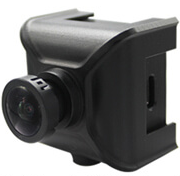
We use OpenCV (cv2) for capturing frames from a USB camera and processing those image frames. Here, we start by setting up the interface to the USB camera and configuring its resolution (1080p). A successful camera setup returns a 'True'. If something is is outputted, shutdown the notebook and restart it again.

In [ ]:
import cv2

camera = cv2.VideoCapture(0)

width = 1920
height = 1080
camera.set(cv2.CAP_PROP_FRAME_WIDTH,width)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT,height)

## Compute opticalflow on USB camera input.

In [ ]:
%%prun -s cumulative -q -l 10 -T prunSW
import numpy as np
import time

ret, frame1 = camera.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
next = np.zeros_like(prvs)
yuv = np.zeros_like(frame1)

num_frames = 5

start = time.time()
for _ in range(num_frames):
    ret, frame2 = camera.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 1, 5, 1.2, 0)
    yuv[...,0] = next[:]
    yuv[...,1] = flow[...,0]*4+128
    yuv[...,2] = flow[...,0]*4+128
    bgr = cv2.cvtColor(yuv,cv2.COLOR_YUV2BGR)
    IPython.display.clear_output(wait=True)
    imshow(bgr)
    prvs[:] = next[:]
tottime_sw_opticalflow = time.time() - start
print("Frames per second: " + str(num_frames/tottime_sw_opticalflow))

## Process SW profile results

In [ ]:
print(open('prunSW','r').read())
res = !cat prunSW | grep calcOpticalFlowFarneback | awk '{{print $$2}}'
tottime_sw_opticalflow = float(res[0])

## Run HW OpticalFlow and measure performance
Now we use opticalflow accelerator in our overlay and accelerate the same OpticalFlow OpenCV function in hardware. From a function signature point of view, it's about as simple as replacing the OpenCV library call (cv2) with a python-extended Xilinx OpenCV function call (xv2) provided to us by the overlay. The algorithm we are using is the dense non-pyramidal Lucas-Kanade opticalflow from the xFOpenCV library.
* [xFOpenCV dense non-pyramidal Lucase-Kanade OpticalFlow](https://github.com/Xilinx/xfopencv/blob/master/include/imgproc/xf_dense_npyr_optical_flow.hpp) ([ug1233](https://www.xilinx.com/support/documentation/sw_manuals/xilinx2018_2/ug1233-xilinx-opencv-user-guide.pdf))

Compute opticalflow on test images.

In [ ]:
%%prun -s tottime -q -l 10 -T prunHW_test
import numpy as np

frame1 = cv2.imread('./images/vtest/scene00002.png')
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
(height,width,channels) = frame1.shape

xFprvs  = mem_manager.cma_array((height,width),np.uint8)
xFnext  = mem_manager.cma_array((height,width),np.uint8)
xFflowX = mem_manager.cma_array((height,width),np.float32)
xFflowY = mem_manager.cma_array((height,width),np.float32)

xFprvs[:] = prvs[:]
yuv = np.zeros_like(frame1)

num_frames = 3

start = time.time()
for i in range(num_frames):
    fileName = ('./images/vtest/scene0000' + str(i+3) + '.png')
    print(fileName)
    frame2 = cv2.imread(fileName)
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    xFnext[:] = next[:]
    xv2.calcOpticalFlowDenseNonPyrLK(xFprvs, xFnext, xFflowX, xFflowY)
    yuv[...,0] = next
    yuv[...,1] = xFflowX[...]*10+128
    yuv[...,2] = xFflowY[...]*10+128
    bgr = cv2.cvtColor(yuv,cv2.COLOR_YUV2BGR)
    imshow(bgr)
    xFprvs[:] = xFnext[:]
tottime_hw_opticalflow = time.time() - start
print("Frames per second: " + str(num_frames/tottime_hw_opticalflow))

## Compute opticalflow on USB camera input.

In [ ]:
%%prun -s tottime -q -l 10 -T prunHW
import numpy as np

ret, frame1 = camera.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
(height,width,channels) = frame1.shape

xFprvs  = mem_manager.cma_array((height,width),np.uint8)
xFnext  = mem_manager.cma_array((height,width),np.uint8)
xFflowX = mem_manager.cma_array((height,width),np.float32)
xFflowY = mem_manager.cma_array((height,width),np.float32)

xFprvs[:] = prvs[:]
yuv = np.zeros_like(frame1)

num_frames = 5

start = time.time()
for i in range(num_frames):
    ret, frame2 = camera.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    xFnext[:] = next[:]
    xv2.calcOpticalFlowDenseNonPyrLK(xFprvs, xFnext, xFflowX, xFflowY)
    yuv[...,0] = next[:]
    yuv[...,1] = xFflowX[...]*10+128
    yuv[...,2] = xFflowY[...]*10+128
    bgr = cv2.cvtColor(yuv,cv2.COLOR_YUV2BGR)
    IPython.display.clear_output(wait=True)
    imshow(bgr)
    xFprvs[:] = xFnext[:]
tottime_hw_opticalflow = time.time() - start
print("Frames per second: " + str(num_frames/tottime_hw_opticalflow))

## Process HW profile results

In [ ]:
print(open('prunHW','r').read())
res = !cat prunHW | grep calcOpticalFlowDenseNonPyrLK | awk '{{print $$2}}'
tottime_hw_opticalflow = float(res[0])

## Plot performance
In addition to having easy access to OpenCV functions, we can access functions from pyPlot for plotting results in graphs and charts. Here, we take the recorded time data and plot out the processing times in a bar chart along with computed FPS of the OpticalFlow function. 

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

TIME_SW_HW   = [t*1000/num_frames for (t) in (tottime_hw_opticalflow, tottime_sw_opticalflow)]
FPS_SW_HW    = [1000/t for (t) in (TIME_SW_HW)]
LABELS       = ['OpticalFlow (HW)','OpticalFlow (SW)']

f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME_SW_HW, height=0.6, color='g', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time per frame [ms]")
ax1.grid(zorder=0)

ax2.barh(x_pos, FPS_SW_HW, height=0.6, color='b', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("Frames per second")
ax2.grid(zorder=0)

plt.show()

## Release USB camera resource

**NOTE**: This is needed to close the camera between subsequent runs. If the camera is unable to read a frame, be sure to call camera.release() and then try opening the VideoCapture again.

In [ ]:
camera.release()

<font color=red size=4>IMPORTANT NOTE</font>: Be sure to run the cell below, shutting down the notebook, before starting a new one. The notebook interface shows "No Kernel", the cell below will incorrectly show a running status [ * ]. You can ignore this an safely close the tab of the notebook.

In [ ]:
%%javascript
Jupyter.notebook.session.delete();